In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd 

In [2]:
def add_colors_multisurvey(df):
    ## Pack the dataframe with necessary colors
    df["coljh"] = df.wjmag - df.whmag
    df["coljk"] = df.wjmag - df.wkmag
    df["colj1"] = df.wjmag - df.w1
    df["colj2"] = df.wjmag - df.w2
    df["colj3"] = df.wjmag - df.w3
    df["colj4"] = df.wjmag - df.w4

    df["colhk"] = df.whmag - df.wkmag
    df["colh1"] = df.whmag - df.w1
    df["colh2"] = df.whmag - df.w2
    df["colh3"] = df.whmag - df.w3
    df["colh4"] = df.whmag - df.w4

    df["colk1"] = df.wkmag - df.w1
    df["colk2"] = df.wkmag - df.w2
    df["colk3"] = df.wkmag - df.w3
    df["colk4"] = df.wkmag - df.w4

    df["col12"] = df.w1 - df.w2
    df["col13"] = df.w1 - df.w3
    df["col14"] = df.w1 - df.w4
    df["col23"] = df.w2 - df.w3
    df["col24"] = df.w2 - df.w4
    df["col34"] = df.w3 - df.w4

    return df

In [3]:
def photo_cuts(df):
    ## Add basic photometry cuts
    sat = {"w1":2.0, "w2":1.5, "w3":-3.0, "k":8.5}
    fnt = {"w1":16.83, "w2":15.6, "w3":11.32, "k":15.5}
    snr = 3
    
    cuts = (df.w1 > sat["w1"]) & (df.w2 > sat["w2"]) & (df.w3 > sat["w3"]) & (df.kmag > sat["k"]) & (df.w1 < fnt["w1"]) & (df.w2 < fnt["w2"]) & (df.w3 < fnt["w3"]) & (df.kmag < fnt["k"]) & (df.w1snr > snr) & (df.w2snr > snr) & (df.w3snr > snr) & (df.ccflag.map(lambda flag: flag.startswith("00")))

    return df[cuts]

def agb_cuts(df):
    ## The basic AGB cuts
    cuts = (df.coljk > 1.1) & (df.col23 < 2.5) & (df.col23 > -0.1)
    
    return df[cuts]

def remove_ysos(df):
    ## For killing AGB stars
    cuts = (df.col12 < 0.2) | (df.col12 > 0.75*df.col23 - 0.33) | (df.col12 < -1. * df.col23 + 1.5)
    
    return df[cuts]

def remove_excess(df):
    ## For removing the excess objects
#     cut = (df.coljk < 2.5 * df.col23 + 1.5) & (df.col23 > 0.4) & ~((df.col12 < 0.3) & (df.col23 > 1.2))
    cut = (df.col23 > 0.4) & (df.ccflag.map(lambda flag: flag.startswith("000"))) & (df.col12 > 0) & ((df.col12 > 0.75*df.col23 - 0.33) | (df.col23 < 1.1)) & (df.col12 < 0.629*df.col23 + 0.359)
    return df[cut]

def all_cuts(df):
    ## Put all of the above together
    return remove_excess(remove_ysos(agb_cuts(photo_cuts(df))))

In [4]:
def draw_line(m, x, b):
    ## Draw a line! Why not?!
    return m*x + b

In [5]:
def all_color_color(infile, figsize=(12,6), interpolation="nearest", cmap=plt.cm.gnuplot, jklim=None, w23hi=None, w23lo=None, outfile=None, binsize=1):
    obj_dir = "/Users/Nick/Documents/AGBstuff/new_work/agb_candidates/"
    df = pd.read_csv(obj_dir + infile, sep=",")
    if "col12" not in df.keys():
#         df = remove_ysos(agb_cuts(photo_cuts(add_colors_multisurvey(df))))
#         df = df[df.glon < 270]
        print len(df)
        df = remove_excess(remove_ysos(agb_cuts(photo_cuts(add_colors_multisurvey(df)))))
        print len(df)
        df.glon[df.glon > 180] = df.glon[df.glon > 180] - 360
    else:
        print len(df)
#         df = df[df.col23 > 0.1]
        df = remove_excess(df[df.col23 > 0.1])
        print len(df)
        
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.25, hspace=0.25, left=0.09, right=0.85, top=0.97, bottom=0.1)
    ax = plt.subplot2grid((2,2),(0,0),colspan=2)

    dx = binsize
    dy = binsize
    
    xbins = np.arange(-180, 180+dx, dx)
    ybins = np.arange(-90, 90+dy, dy)
    H, xedges, yedges = np.histogram2d(df.glon, df.glat, bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    imap = ax.imshow(np.log10(H.T), extent=extent, aspect="auto", interpolation=interpolation, cmap=cmap, origin="lower")

    ax.set_xlim(-180, 180)
    ax.set_xlabel("gal $l$ (deg)")
    ax.set_ylim(-90, 90)
    ax.set_ylabel("gal $b$ (deg)")
    ax.minorticks_on()

    
    ax = plt.subplot2grid((2,2),(1,0))
    xcolor = df.col23
    ycolor = df.coljk
    dx = dy = 0.05
    
    xbins = np.arange(-4, 5.+dx, dx)
    ybins = np.arange(-4, 5.+dy, dy)

    H, xedges, yedges = np.histogram2d(xcolor, ycolor, bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(np.log10(H.T), extent=extent, aspect="auto", interpolation=interpolation, cmap=cmap, origin="lower")

    if jklim:
        ax.plot([-1,4],[jklim,jklim],linestyle="--",color='white', linewidth=2)
    if w23hi:
        ax.plot([w23hi,w23hi],[-2,6],linestyle="--",color='k', linewidth=2)
    if w23lo:
        print w23lo
        ax.plot([w23lo,w23lo],[-2,6],linestyle="--",color='k', linewidth=2)

#     ax.set_xticks(np.arange(0, 4.+1., 1.))
    ax.set_xlim(0, 2.5)
    ax.set_xlabel("W2 - W3")
    ax.set_yticks(np.arange(0, 4.+1., 1.))
    ax.set_ylim(0.5, 4.4)
    ax.set_ylabel("J - K$_s$")
    ax.minorticks_on()

    ax = plt.subplot2grid((2,2),(1,1))
    xcolor = df.col23
    ycolor = df.col12
    dx = 0.05
    dy = 0.05
    
    xbins = np.arange(-0.5, 3.9+dx, dx)
    ybins = np.arange(-0.5, 3.9+dy, dy)
    
    H, xedges, yedges = np.histogram2d(xcolor, ycolor, bins=(xbins, ybins))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(np.log10(H.T), extent=extent, aspect="auto", interpolation=interpolation, cmap=cmap, origin="lower")
    if w23hi:
        ax.plot([w23hi,w23hi],[-2,6],linestyle="--",color='k', linewidth=2)
    if w23lo:
        ax.plot([w23lo,w23lo],[-2,6],linestyle="--",color='k', linewidth=2)

    ax.set_xlim(0, 2.5)
    ax.set_xlabel("W2-W3")
    ax.set_ylim(-0.5, 1.9)
    ax.set_ylabel("W1-W2")
    ax.minorticks_on()

#     cax = fig.add_axes([0.86, 0.1, 0.04, 0.87]) 
#     cbar = plt.colorbar(imap, cax = cax, ticks=np.arange(vmin, 1.0+0.1, 0.1))
    
    if outfile:
        plt.savefig(outfile)

    plt.show()

300745
5662


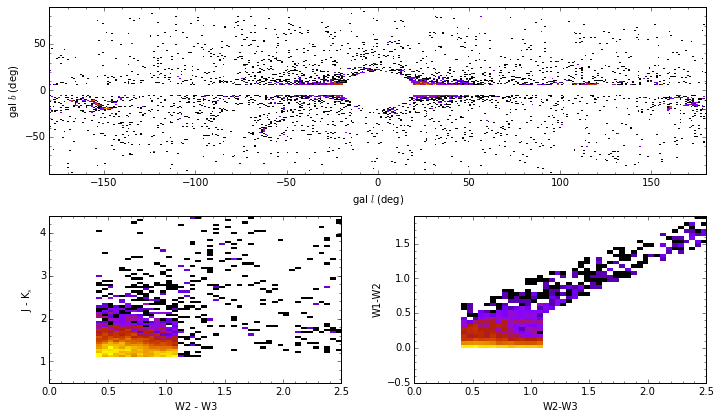

1622189
41622


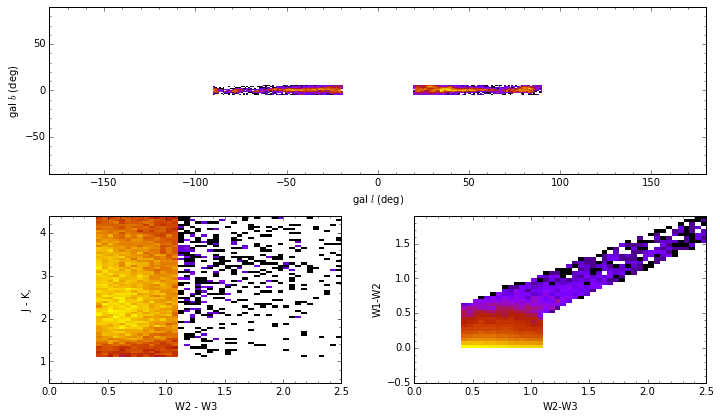

236638
9447


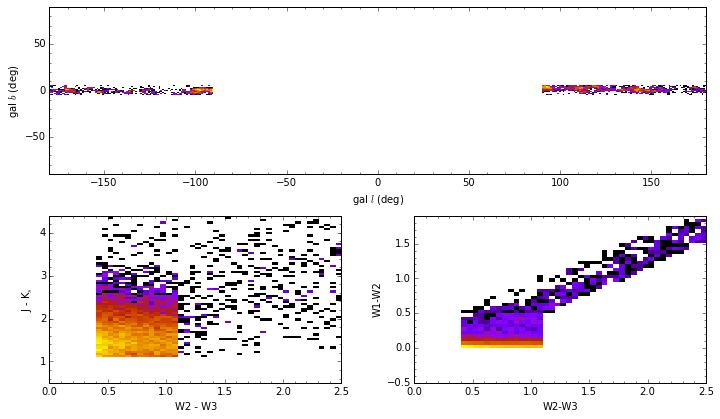

693598
13615


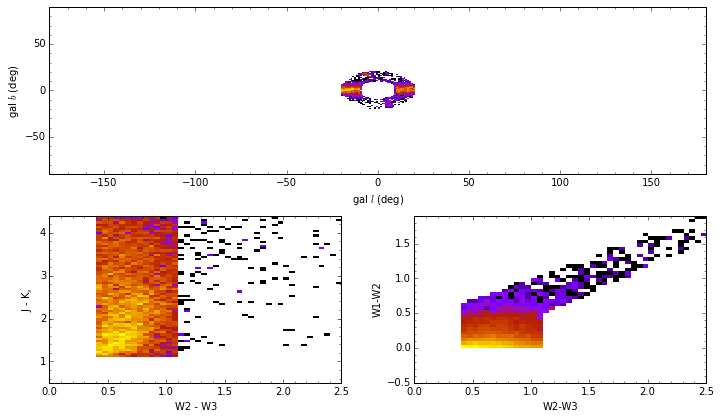

648273
8553


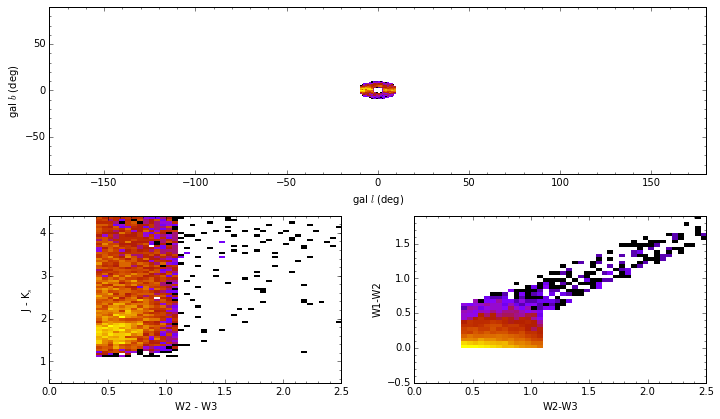

46414
1478


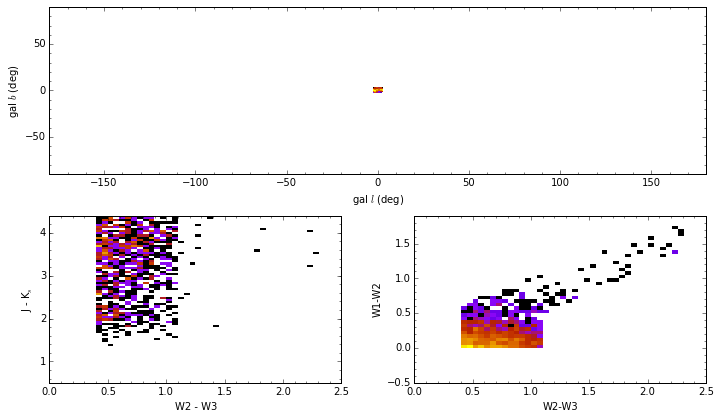

In [6]:
all_color_color("candidates_region_0.dat")
all_color_color("candidates_region_1.dat")
all_color_color("candidates_region_2.dat")
all_color_color("candidates_region_3.dat")
all_color_color("candidates_region_4.dat")
all_color_color("candidates_region_5.dat")


50342
2445


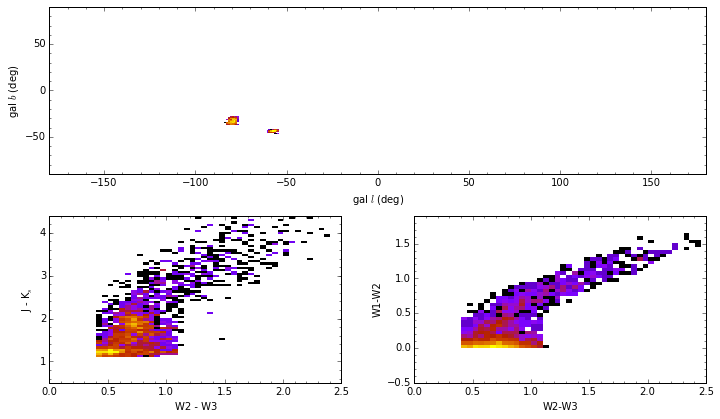

In [7]:
all_color_color("../samples/ogle_2mass_allwise_alldata.dat")

In [8]:
print 78999 + 587924 + 65605 + 233493 + 108242 + 5923 # W2-W3 > 0.4 & w1-3 ccflag == 0
print 72218 + 289082 + 63758 + 70482 + 22793 + 2863 # W2-W3 > 0.4 & w1-3 ccflag == 0 & W1-W2 > -0.1
print 45088 + 86936 + 24669 + 21301 + 10984 + 2648 # W2-W3 > 0.4 & w1-3 ccflag == 0 & W1-W2 > 0
print 44972 + 86162 + 24486 + 21027 + 10773 + 1799 # W2-W3 > 0.4 & w1-3 ccflag == 0 & W1-W2 > 0 & c-rich spine
print 8477 + 53266 + 12901 + 15904 + 9539 + 1645 # W2-W3 > 0.4 & w1-3 ccflag == 0 & W1-W2 > 0 & c-rich spine & enhanced YSO cut
print 6264 + 45347 + 10432 + 14436 + 8999 + 1553# W2-W3 > 0.4 & w1-3 ccflag == 0 & W1-W2 > 0 & c-rich spine & enhanced YSO cut with W2-W3 < 1.2
# print 1335 + 9617 + 1087 + 4083 + 2795 + 691 # W2-W3 > 0.4 & w1-w3 ccflag == 0 & W1-W2 > 0.2


1080186
521196
191626
189219
101732
87031


In [9]:
obj_dir = "/Users/Nick/Documents/AGBstuff/new_work/agb_candidates/"
lmc = add_colors_multisurvey(pd.read_csv(obj_dir + "../samples/ogle_2mass_allwise_alldata.dat", sep=","))
lmc = all_cuts(photo_cuts(lmc))
lmc = lmc[lmc.glon < 290]
# lmc = remove_excess(remove_ysos(agb_cuts(photo_cuts(add_colors_multisurvey(lmc)))))

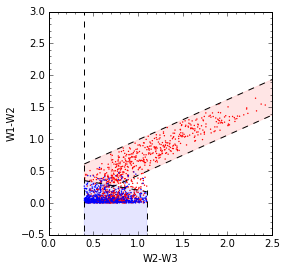

======== O-rich Region: ========
O-rich star count: 521/564
O-rich completeness (%): 92.3758865248
C-rich contamination (%): 55.0086355786

======== C-rich Region: ========
C-rich star count: 495/1172
C-rich completeness (%): 42.2354948805
O-rich contamination (%): 6.42722117202


In [23]:
x = np.linspace(0.4,3,100)
x1 = np.linspace(0.4,0.7,100)
x2 = np.linspace(0.7,3,100)

fig = plt.figure(figsize=(4,4))
fig.subplots_adjust(wspace=0.3)
# ax = plt.subplot(221)
# ax.scatter(lmc[lmc.Spectr == "C-rich"].col23, lmc[lmc.Spectr == "C-rich"].coljk, s=2, edgecolor="None", c='r')
# ax.scatter(lmc[lmc.Spectr == "O-rich"].col23, lmc[lmc.Spectr == "O-rich"].coljk, s=2, edgecolor="None", c='b')
# # ax.plot(x, draw_line(0, x, 1.4), linestyle="--", color="k")
# # ax.fill_between([0, 2.5], [0,0], [1.4,1.4], color="b", alpha=0.1)
# # ax.fill_between([0, 2.5], [1.4,1.4], [5,5], color="r", alpha=0.1)
# ax.minorticks_on()
# ax.set_xlim(0,2.5)
# ax.set_ylim(1,5)
# ax.set_ylabel("$J-K_s$")
# ax.set_xlabel("W2-W3")

ax = plt.subplot(111)
ax.scatter(lmc[lmc.Spectr == "C-rich"].col23, lmc[lmc.Spectr == "C-rich"].col12, s=2, edgecolor="None", c='r')
ax.scatter(lmc[lmc.Spectr == "O-rich"].col23, lmc[lmc.Spectr == "O-rich"].col12, s=2, edgecolor="None", c='b')
ax.plot([0.4, 1.1], draw_line(-0.25, np.array([0.4,1.1]), 0.45), color='k', linestyle="--")
ax.plot([0.4,0.4], [-1,4], linestyle="--", color='k')
ax.plot([1.1,1.1], [-1,0.2], linestyle="--", color='k')
ax.plot(x, draw_line(0.629, x, 0.359), color='k', linestyle="--")
ax.plot(x2, draw_line(0.629, x2, -0.198), color='k', linestyle="--")
ax.fill_between(x1, draw_line(-0.25, x1, 0.45), draw_line(0.629, x1, 0.359), color='r', alpha=0.1)
ax.fill_between(x2, draw_line(0.629, x2, -0.198), draw_line(0.629, x2, 0.359), color='r', alpha=0.1)
ax.fill_between([0.4, 1.1], [-1,-1],draw_line(-0.25, np.array([0.4,1.1]), 0.45), color='b', alpha=0.1)
ax.minorticks_on()
ax.set_xlim(0,2.5)
ax.set_ylim(-0.5, 3)
ax.set_ylabel("W1-W2")
ax.set_xlabel("W2-W3")

# ax = plt.subplot(223)
# ax.scatter(lmc[lmc.Spectr == "C-rich"].col23, lmc[lmc.Spectr == "C-rich"].colk3, s=2, edgecolor="None", c='r')
# ax.scatter(lmc[lmc.Spectr == "O-rich"].col23, lmc[lmc.Spectr == "O-rich"].colk3, s=2, edgecolor="None", c='b')
# ax.minorticks_on()
# ax.set_xlim(0,2.5)
# ax.set_ylim(0.4, 5)
# ax.set_ylabel("$K_s$-W3")
# ax.set_xlabel("W2-W3")

# ax = plt.subplot(224)
# ax.scatter(lmc[lmc.Spectr == "C-rich"].col23, lmc[lmc.Spectr == "C-rich"].colj1, s=2, edgecolor="None", c='r')
# ax.scatter(lmc[lmc.Spectr == "O-rich"].col23, lmc[lmc.Spectr == "O-rich"].colj1, s=2, edgecolor="None", c='b')
# ax.minorticks_on()
# ax.set_xlim(0,2.5)
# ax.set_ylim(0.4, 6)
# ax.set_ylabel("$J$-W1")
# ax.set_xlabel("W2-W3")

plt.show()

print "======== O-rich Region: ========"
orich = (lmc.col23 > 0.4) & (lmc.col23 < 1.1) & (lmc.col12 < -0.25*lmc.col23 + 0.45) & (lmc.Spectr == "O-rich")
crich_contam = (lmc.col23 > 0.4) & (lmc.col23 < 1.1) & (lmc.col12 < -0.25*lmc.col23 + 0.45) & (lmc.Spectr == "C-rich")
print "O-rich star count: {0}/{1}".format(sum(orich), sum(lmc.Spectr=="O-rich"))
print "O-rich completeness (%): {0}".format(sum(orich) / float(sum(lmc.Spectr == "O-rich")) * 100)
print "C-rich contamination (%): {0}".format(sum(crich_contam) / float(sum(crich_contam) + sum(orich)) * 100)

print "\n======== C-rich Region: ========"
crich = (lmc.col12 > 0.629*lmc.col23 - 0.198) & (lmc.col12 < 0.629*lmc.col23 + 0.359) & (lmc.col12 > -0.25*lmc.col23 + 0.45) & (lmc.Spectr == "C-rich")
orich_contam = (lmc.col12 > 0.629*lmc.col23 - 0.198) & (lmc.col12 < 0.629*lmc.col23 + 0.359) & (lmc.col12 > -0.25*lmc.col23 + 0.45) & (lmc.Spectr == "O-rich")
print "C-rich star count: {0}/{1}".format(sum(crich), sum(lmc.Spectr=="C-rich"))
print "C-rich completeness (%): {0}".format(sum(crich) / float(sum(lmc.Spectr == "C-rich")) * 100)
print "O-rich contamination (%): {0}".format(sum(orich_contam) / float(sum(crich) + sum(orich_contam)) * 100)



### We've defined our C-rich/O-rich separation. Now, let's see if we can use scikit-learn's Stochastic Gradient Descent Regressor to determine the relationship between W1 and the following colors:
- J-K
- K-W1
- W1-W2
- W2-W3

In [38]:
from sklearn.linear_model import SGDRegressor, LinearRegression

In [39]:
DM_lmc = 18.32
lmc.Mw1 = lmc.w1 - DM_lmc

In [48]:
features1 = lmc[['coljk', 'colk1', 'col12', 'col23']][orich]
features2 = lmc[['coljk', 'colk1', 'col12', 'col23']][crich]
values1 = lmc.Mw1[orich]
values2 = lmc.Mw1[crich]
lm1 = LinearRegression()
lm2 = LinearRegression()
lm1.fit(features1, values1)
lm2.fit(features2, values2)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [49]:
predicted1 = lm1.predict(features1)
predicted2 = lm2.predict(features2)
coeffs1 = lm1.coef_
coeffs2 = lm2.coef_
Mw1_01 = lm1.intercept_
Mw1_02 = lm2.intercept_
print "C-rich fit stdev: {0}".format(np.sqrt(np.sum((values1 - predicted1)**2)/float(len(values1))))
print "O-rich fit stdev: {0}".format(np.sqrt(np.sum((values2 - predicted2)**2)/float(len(values2))))

C-rich fit stdev: 0.43104361795
O-rich fit stdev: 0.46227473409


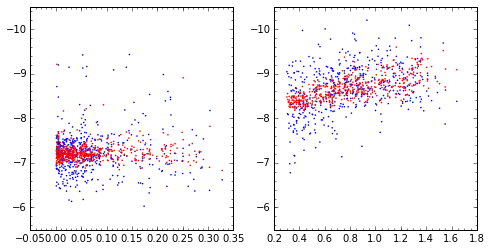

In [52]:
xtest = np.linspace(lmc.col12.min(), lmc.col12.max(), 11)
fig = plt.figure(figsize=(8,4))

ax = plt.subplot(121)
ax.scatter(lmc.col12[orich], lmc.Mw1[orich], edgecolor="None", s=2.5)
ax.scatter(lmc.col12[orich], predicted1, c='r', edgecolor="None", s=2.5)
ax.minorticks_on()
ax.set_ylim(-5.5, -10.5)

ax = plt.subplot(122)
ax.scatter(lmc.col12[crich], lmc.Mw1[crich], edgecolor="None", s=2.5)
ax.scatter(lmc.col12[crich], predicted2, c='r', edgecolor="None", s=2.5)
ax.minorticks_on()
ax.set_ylim(-5.5, -10.5)

plt.show()

### We have better selection criteria now, as well as C-rich/O-rich separation. Let's see the distribution of our candidates

In [ ]:
data = all_cuts(pd.read_csv(obj_dir + "candidates_region_0.dat", sep=","))
for ii in range(1, 6):
    d = all_cuts(pd.read_csv(obj_dir + "candidates_region_{0}.dat".format(ii), sep=","))
    data = pd.concat((data,d))

In [ ]:
data[data.glon > 180] = data[data.glon > 180] - 360
crich = (data.col12 > 0.629*data.col23 - 0.198) & (data.col12 < 0.629*data.col23 + 0.359) & (data.col12 > -0.25*data.col23 + 0.45)
orich = (data.col23 > 0.4) & (data.col23 < 1.1) & (data.col12 < -0.25*data.col23 + 0.45)

In [ ]:
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(wspace = 0.3)
ax = plt.subplot(221)
ax.scatter(data[crich].col23, data[crich].coljk, s=2, edgecolor="None", c='r')
ax.scatter(data[orich].col23, data[orich].coljk, s=2, edgecolor="None", c='b')
ax.minorticks_on()
ax.set_xlim(0,3.0)
ax.set_ylim(1, 8)
ax.set_ylabel("$J-K_s$")
ax.set_xlabel("W2-W3")

ax = plt.subplot(222)
ax.scatter(data[crich].col23, data[crich].col12, s=2, edgecolor="None", c='r')
ax.scatter(data[orich].col23, data[orich].col12, s=2, edgecolor="None", c='b')
ax.minorticks_on()
ax.set_xlim(0,3.0)
ax.set_ylim(-0.5, 3)
ax.set_ylabel("W1-W2")
ax.set_xlabel("W2-W3")

ax = plt.subplot(223)
ax.scatter(data[crich].col23, data[crich].colj1, s=2, edgecolor="None", c='r')
ax.scatter(data[orich].col23, data[orich].colj1, s=2, edgecolor="None", c='b')
ax.minorticks_on()
ax.set_xlim(0,3.0)
ax.set_ylim(1, 10)
ax.set_ylabel("$J$-W1")
ax.set_xlabel("W2-W3")

plt.savefig("../figures/orich_crich_candidates_colorcolor.png")
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(left=0.1, right=0.88, top=0.95, bottom=0.1)
ax = plt.subplot(211)
ax.scatter(data[crich].glon, data[crich].glat, s=1, edgecolor="None", c='r')
ax.text(0.05, 0.2, 'Total "C-rich" AGB Candidates: {0}'.format(sum(crich)), transform=ax.transAxes)
ax.text(0.05, 0.1, '"C-rich" AGB Candidates in region: {0}'.format(sum(crich & (abs(data.glon) < 30) & (abs(data.glat) < 30))), transform=ax.transAxes)
ax.minorticks_on()
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_xlabel("glon")
ax.set_ylabel("glat")

ax = plt.subplot(212)
H, xed, yed = np.histogram2d(data[crich].glon, data[crich].glat, bins=(np.arange(-180,181,1), np.arange(-90,91,1)))
extent = [xed[0], xed[-1], yed[0], yed[-1]]
imap = ax.contour(np.log10(H.T), levels=np.arange(0,2.25,0.25), extent=extent, aspect="auto", interpolation="nearest", origin='lower')

cax = fig.add_axes([0.9, 0.1, 0.02, 0.85])
cbar = fig.colorbar(imap, cax = cax)
cbar.ax.set_ylabel("log(N) Objects", fontsize=12)

ax.minorticks_on()
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_xlabel("glon")
ax.set_ylabel("glat")

plt.savefig("../figures/candidates_crich_galcenter.png")
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(left=0.1, right=0.88, top=0.95, bottom=0.1)
ax = plt.subplot(211)
ax.scatter(data[orich].glon, data[orich].glat, s=1, edgecolor="None", c='b')
ax.text(0.05, 0.2, 'Total "O-rich" AGB Candidates: {0}'.format(sum(orich)), transform=ax.transAxes)
ax.text(0.05, 0.1, '"O-rich" AGB Candidates in region: {0}'.format(sum(orich & (abs(data.glon) < 30) & (abs(data.glat) < 30))), transform=ax.transAxes)
ax.minorticks_on()
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_xlabel("glon")
ax.set_ylabel("glat")

ax = plt.subplot(212)
H, xed, yed = np.histogram2d(data[orich].glon, data[orich].glat, bins=(np.arange(-180,181,1), np.arange(-90,91,1)))
extent = [xed[0], xed[-1], yed[0], yed[-1]]
imap = ax.contour(np.log10(H.T), levels=np.arange(0,2.25,0.25), extent=extent, aspect="auto", interpolation="nearest", origin='lower')

cax = fig.add_axes([0.9, 0.1, 0.02, 0.85])
cbar = fig.colorbar(imap, cax = cax)
cbar.ax.set_ylabel("log(N) Objects", fontsize=12)

ax.minorticks_on()
ax.set_xlim(-30,30)
ax.set_ylim(-30,30)
ax.set_xlabel("glon")
ax.set_ylabel("glat")

plt.savefig("../figures/candidates_orich_galcenter.png")
plt.show()

In [ ]:
print sum(crich)
print sum(orich)

In [ ]:
fig = plt.figure(figsize=(8,4))
# fig.subplots_adjust(wspace=0.3)
ax = plt.subplot(111)
ax.scatter(data[crich].glon, data[crich].glat, s=2, edgecolor="None", c='r')
ax.scatter(data[orich].glon, data[orich].glat, s=2, edgecolor="None", c='b')
ax.minorticks_on()
ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax.set_xlabel("glon")
ax.set_ylabel("glat")


plt.show()